In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

In [2]:
# Susceptible equation
def dS_dt(S, I, R_t, t_inf):
    return -(R_t / t_inf) * I * S


# Exposed equation
def dE_dt(S, E, I, R_t, t_inf, t_inc):
    return (R_t / t_inf) * I * S - (E / t_inc)


# Infected equation
def dI_dt(I, E, t_inc, t_inf):
    return (E / t_inc) - (I / t_inf)

# Hospialized equation
def dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a):
    return ((1 - m_a) * (I / t_inf)) + ((1 - f_a) * C / t_crit) - (H / t_hosp)


# Critical equation
def dC_dt(H, C, t_hosp, t_crit, c_a):
    return (c_a * H / t_hosp) - (C / t_crit)


# Recovered equation
def dR_dt(I, H, t_inf, t_hosp, m_a, c_a):
    return (m_a * I / t_inf) + (1 - c_a) * (H / t_hosp)


# Deaths equation
def dD_dt(C, t_crit, f_a):
    return f_a * C / t_crit

def SEIR_HCD_model(t, y, R_t, t_inc=2.9, t_inf=5.2, t_hosp=4, t_crit=14, m_a=0.8, c_a=0.1, f_a=0.3):
    """

    :param t: Time step for solve_ivp
    :param y: Previous solution or initial values
    :param R_t: Reproduction number
    :param t_inc: Average incubation period. Default 5.2 days
    :param t_inf: Average infectious period. Default 2.9 days
    :param t_hosp: Average time a patient is in hospital before either recovering or becoming critical. Default 4 days
    :param t_crit: Average time a patient is in a critical state (either recover or die). Default 14 days
    :param m_a: Fraction of infections that are asymptomatic or mild. Default 0.8
    :param c_a: Fraction of severe cases that turn critical. Default 0.1
    :param f_a: Fraction of critical cases that are fatal. Default 0.3
    :return:
    """
    if callable(R_t):
        reprod = R_t(t)
    else:
        reprod = R_t
        
    S, E, I, R, H, C, D = y
    
    S_out = dS_dt(S, I, reprod, t_inf)
    E_out = dE_dt(S, E, I, reprod, t_inf, t_inc)
    I_out = dI_dt(I, E, t_inc, t_inf)
    R_out = dR_dt(I, H, t_inf, t_hosp, m_a, c_a)
    H_out = dH_dt(I, C, H, t_inf, t_hosp, t_crit, m_a, f_a)
    C_out = dC_dt(H, C, t_hosp, t_crit, c_a)
    D_out = dD_dt(C, t_crit, f_a)
    return [S_out, E_out, I_out, R_out, H_out, C_out, D_out]

In [3]:
def plot_model(solution, title='SEIR+HCD model'):
    sus, exp, inf, rec, hosp, crit, death = solution.y
    
    cases = inf + rec + hosp + crit + death

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle(title)
    
    ax1.plot(sus, 'tab:blue', label='Susceptible');
    ax1.plot(exp, 'tab:orange', label='Exposed');
    ax1.plot(inf, 'tab:red', label='Infected');
    ax1.plot(rec, 'tab:green', label='Recovered');
    ax1.plot(hosp, 'tab:purple', label='Hospitalised');
    ax1.plot(crit, 'tab:brown', label='Critical');
    ax1.plot(death, 'tab:cyan', label='Deceased');
    
    ax1.set_xlabel("Days", fontsize=10);
    ax1.set_ylabel("Fraction of population", fontsize=10);
    ax1.legend(loc='best');
    ax2.plot(cases, 'tab:red', label='Cases');    
    ax2.set_xlabel("Days", fontsize=10);
    ax2.set_ylabel("Fraction of population (Cases)", fontsize=10, color='tab:red');
    
    ax3 = ax2.twinx()
    ax3.plot(death, 'tab:cyan', label='Deceased');    
    ax3.set_xlabel("Days", fontsize=10);
    ax3.set_ylabel("Fraction of population (Fatalities)", fontsize=10, color='tab:cyan');

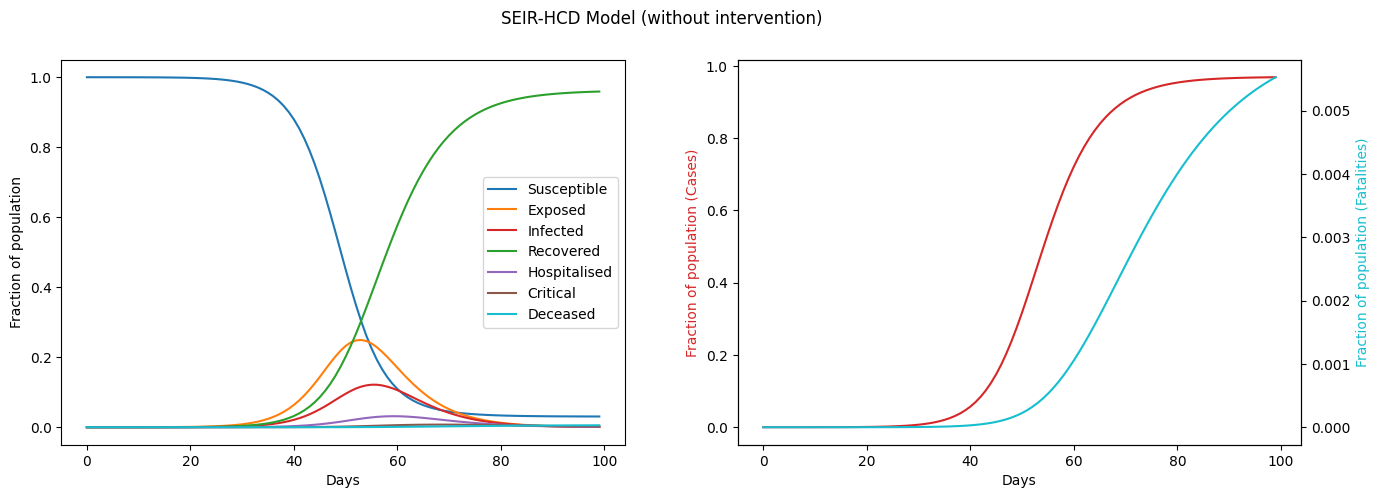

In [4]:
N = 100000  # Population size
n_infected = 1
max_days = 100

# State at time = 0 for SEIR_HCD model
# The numbers correspond to the number of people in each of the SEIRHCD compartments
initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0, 0, 0, 0]

R_0 = 3.6
t_inc = 5.6
t_inf = 2.9
t_hosp = 4
t_crit = 14
m_a = 0.8
c_a = 0.1
f_a = 0.3

args = (R_0, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
sol = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol, 'SEIR-HCD Model (without intervention)')

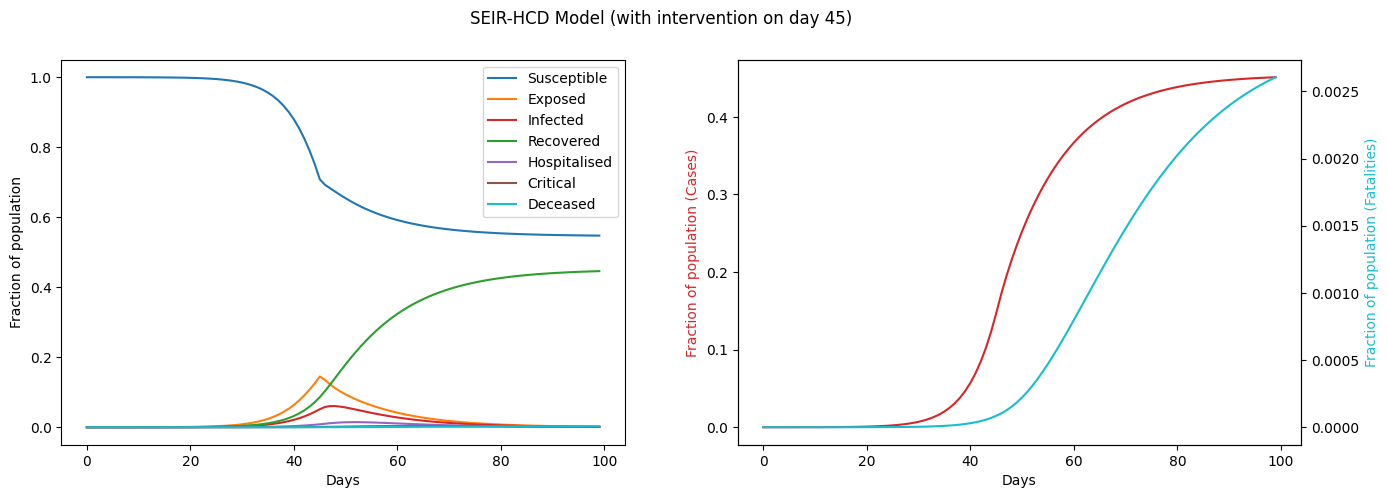

In [5]:
R_0 = 3.6 # reproduction number without intervention
R_t = 0.7  # reproduction number after intervention
intervention_day = 45

def time_varying_reproduction(t):
    if t > intervention_day:
        return R_t
    else:
        return R_0
    
args = (time_varying_reproduction, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)

sol2 = solve_ivp(SEIR_HCD_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

plot_model(sol2, f'SEIR-HCD Model (with intervention on day {intervention_day})')